<a href="https://colab.research.google.com/github/kayleepho/MATH-5750-Project-2/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In this exercise, I will perform a cluster analysis on a synthetically generated “Gaussian Blobs” dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)


In [2]:
# Perform a k-means cluster analysis with k = 5. Report the smallest k-means inertia value.
kmeans = KMeans(n_clusters=5, n_init=20, random_state=42).fit(X)
print("Smallest k-means inertia value:", kmeans.inertia_)

Smallest k-means inertia value: 924.3159961688092


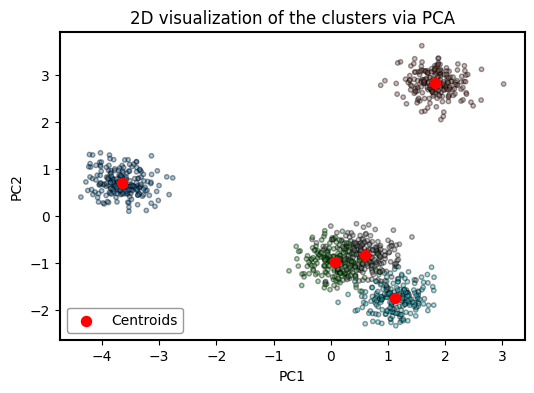

In [8]:
# Make a 2D visualization of the clusters via PCA
# Including both the clusters (colored by cluster) and the cluster centers.

# Reduce data to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
centers_pca = pca.transform(kmeans.cluster_centers_)

# Plot the clusters and cluster centers
plt.figure(figsize=(6,4), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

# Plot data points
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans.labels_,
            cmap="tab10", s=10, edgecolor="black", alpha=0.4)

# Plot red dot centroids
plt.scatter(
    centers_pca[:,0], centers_pca[:,1],
    c="red", s=45, marker="o", linewidth=1.5, label="Centroids"
)

plt.title("2D visualization of the clusters via PCA")
plt.legend(loc="lower left", facecolor="white", edgecolor="gray")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

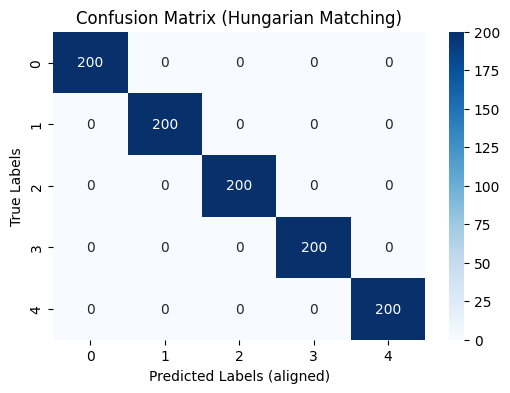

In [14]:
from scipy.optimize import linear_sum_assignment

# Compute raw confusion matrix
cm = confusion_matrix(y_true, kmeans.labels_)

# Use Hungarian Algorithm to match labels optimally
row_ind, col_ind = linear_sum_assignment(-cm)  # maximize matches
cm_aligned = cm[:, col_ind]

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_aligned, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels (aligned)")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Hungarian Matching)")
plt.show()


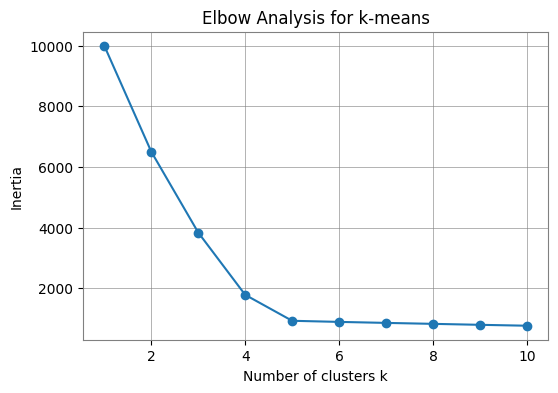

In [13]:
inertias = []
ks = range(1, 11)
for k in ks:
    km = KMeans(n_clusters=k, n_init=50, random_state=1)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(ks, inertias, '-o')
plt.gca().set_facecolor("white")  # white background
plt.grid(True, color="gray", linewidth=0.7, alpha=0.6)
for spine in plt.gca().spines.values():
    spine.set_edgecolor("gray")
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")
plt.title("Elbow Analysis for k-means")
plt.show()

# 2. Clustering Fashion-MNIST using $k$-means

In this exercise, I will import and perform
a cluster analysis on the Fashion-MNIST dataset.

In [15]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


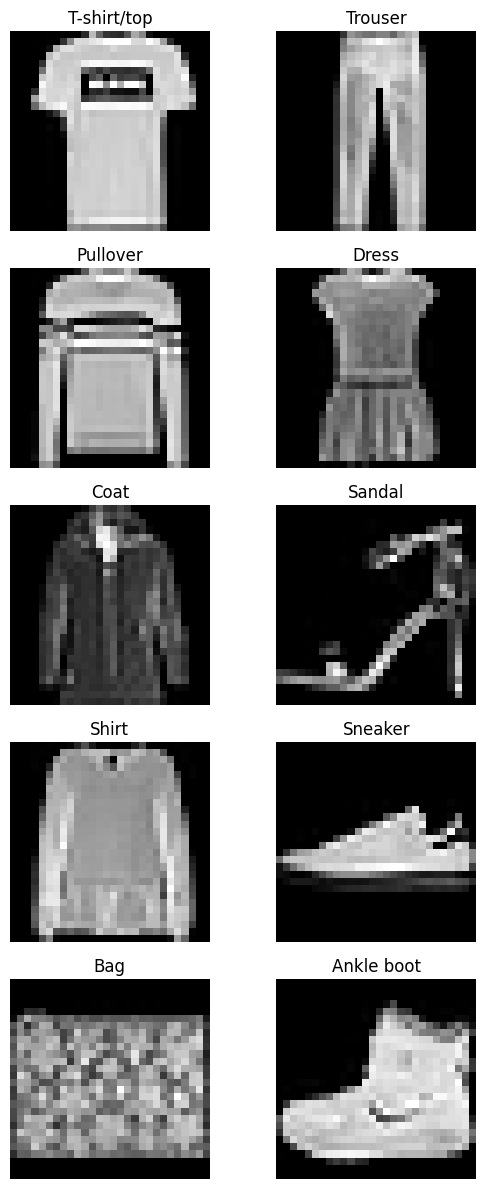

In [17]:
import matplotlib.pyplot as plt

# a 5×2 array of figures, each plotting a distinct article of clothing.
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, axes = plt.subplots(5, 2, figsize=(6, 12))
axes = axes.flatten()

for i in range(10):
    # Find the first index of each class
    idx = np.where(y == i)[0][0]
    image = X[idx].reshape(28, 28)

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Cluster labels shape: (10000,)


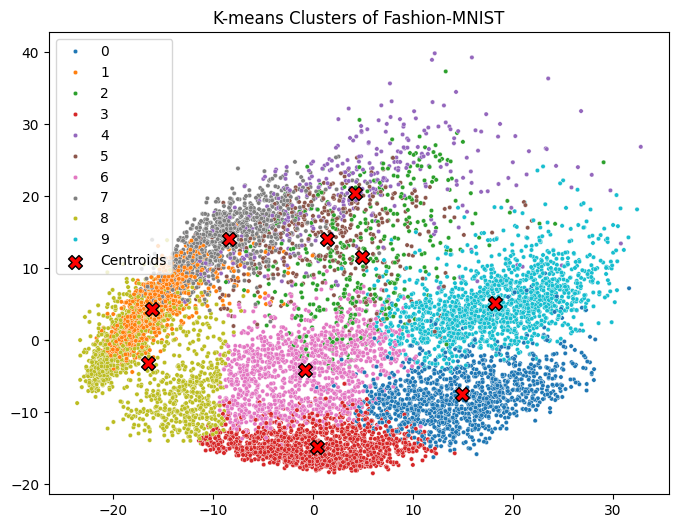

In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

# Take a random sample to reduce computation
sample_size = 10000
idx = np.random.choice(range(X.shape[0]), size=sample_size, replace=False)
X_sample = X[idx]

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# Reduce to 50D using PCA (before clustering)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Run K-means with 10 clusters
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

print("Cluster labels shape:", clusters.shape)

# Visualize clusters (2D PCA projection)

pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_pca)

centroids_2d = pca2.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_2d[:,0], y=X_2d[:,1],
    hue=clusters, palette="tab10", s=10, legend="full"
)

# Plot centroids as red dots
plt.scatter(
    centroids_2d[:,0], centroids_2d[:,1],
    c="red", s=100, marker="X", edgecolor="black", label="Centroids"
)

plt.title("K-means Clusters of Fashion-MNIST")
plt.legend()
plt.show()

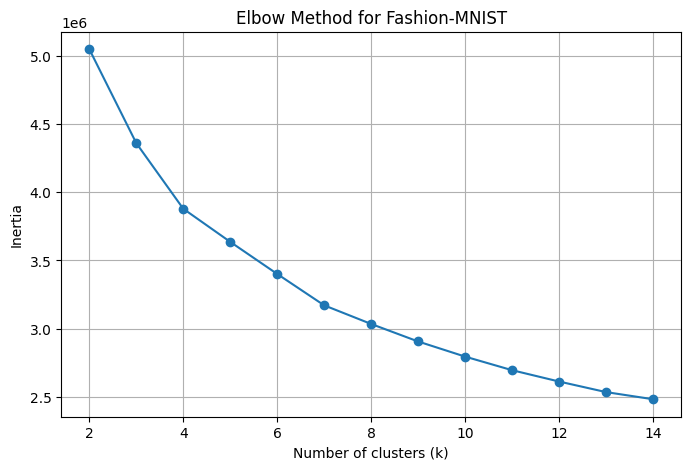

In [22]:
inertias = []
K_range = range(2, 15)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca)   # use PCA-reduced data (e.g., 50D)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Fashion-MNIST")
plt.grid(True)
plt.show()

# 3. Dimensionality reduction for Fashion-MNIST

In this exercise, I will compare PCA and Random Projection on the Fashion-MNIST dataset. The goal of this exercise is to better understand how Random Projections performs as we vary dimension (Johnson–Lindenstrauss Lemma).

In [25]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

# Center and scale the features (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check shapes and types
print(type(X_scaled), X_scaled.shape)
print(type(y),y.shape)


<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


In [ ]:
# Implement both PCA and Random Projection methods
# for target dimensions k∈{10,20,50,100,200}.
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection

# Optional: sample a subset to speed up computations
X_sub = X_scaled[:3000]

# Target dimensions
dims = [10, 20, 50, 100, 200]

# Dictionaries to store reduced data
pca_results = {}
rp_results = {}

for k in dims:
    # PCA
    pca = PCA(n_components=k, random_state=42)
    X_pca = pca.fit_transform(X_sub)
    pca_results[k] = X_pca

    # Random Projection
    rp = GaussianRandomProjection(n_components=k, random_state=42)
    X_rp = rp.fit_transform(X_sub)
    rp_results[k] = X_rp

# Example: check shape of reduced data
for k in dims:
    print(f"k={k}: PCA shape={pca_results[k].shape}, RP shape={rp_results[k].shape}")


In [ ]:
# For each reduced dataset, compute the correlation between pairwise distances
# in the original standardized space and the reduced space.
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Compute pairwise distances in the original space
dist_original = pdist(X_sub, metric='euclidean')

# Store correlations
dims = [10, 20, 50, 100, 200]
corr_pca = []
corr_rp = []

for k in dims:
    # PCA distances
    dist_pca = pdist(pca_results[k], metric='euclidean')
    corr_pca.append(np.corrcoef(dist_original, dist_pca)[0, 1])

    # Random Projection distances
    dist_rp = pdist(rp_results[k], metric='euclidean')
    corr_rp.append(np.corrcoef(dist_original, dist_rp)[0, 1])

# Display correlations
for i, k in enumerate(dims):
    print(f"k={k}: PCA correlation={corr_pca[i]:.4f}, RP correlation={corr_rp[i]:.4f}")


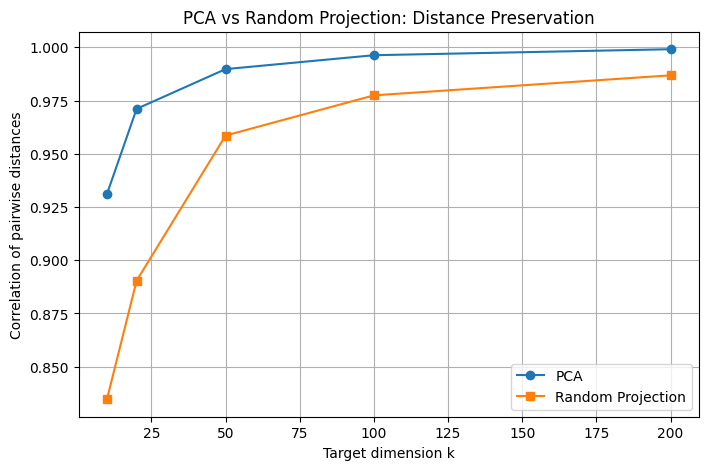

In [31]:
# Make a plot of this correlation vs. k for the two methods
import matplotlib.pyplot as plt

# Target dimensions
dims = [10, 20, 50, 100, 200]

plt.figure(figsize=(8,5))
plt.plot(dims, corr_pca, marker='o', label='PCA')
plt.plot(dims, corr_rp, marker='s', label='Random Projection')
plt.xlabel("Target dimension k")
plt.ylabel("Correlation of pairwise distances")
plt.title("PCA vs Random Projection: Distance Preservation")
plt.grid(True)
plt.legend()
plt.show()

# 4. Clustering Fashion-MNIST using spectral clustering

In this exercise, I will again perform a cluster analysis on the Fashion-MNIST dataset.


Cluster labels for first 10 samples: [1 7 3 4 6 1 0 4 2 6]


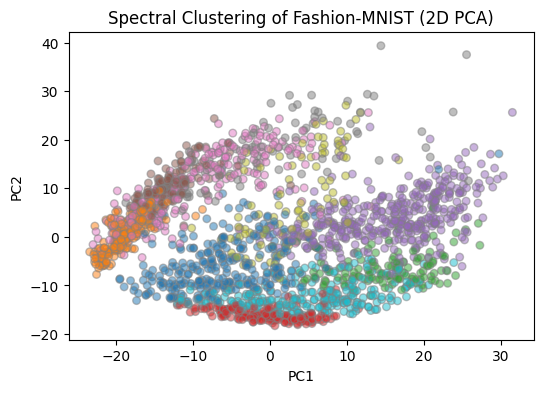

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Load Fashion-MNIST
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

# Sample a subset for speed
sample_size = 2000
idx = np.random.choice(range(X.shape[0]), size=sample_size, replace=False)
X_sample = X[idx]
y_sample = y[idx]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# Optional: reduce dimensionality with PCA to speed up spectral clustering
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Spectral clustering
spectral = SpectralClustering(
    n_clusters=10,               # 10 clothing categories
    affinity='nearest_neighbors', # similarity graph
    n_neighbors=10,               # neighbors for graph
    assign_labels='kmeans',       # final labeling
    random_state=42
)
labels = spectral.fit_predict(X_pca)

# Check cluster assignments
print("Cluster labels for first 10 samples:", labels[:10])

# Optional: 2D visualization using PCA
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_pca)

plt.figure(figsize=(6,4))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='tab10', s=30, edgecolor='gray', alpha=0.5)
plt.title("Spectral Clustering of Fashion-MNIST (2D PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load Fashion-MNIST
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
X, y = fashion_mnist['data'], fashion_mnist['target'].astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Reduce dimensions to 50
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X_scaled)

In [ ]:
# Subsample 10,000 points
np.random.seed(42)
subset_idx = np.random.choice(len(X_reduced), size=10000, replace=False)
X_subset = X_reduced[subset_idx]
y_subset = y[subset_idx]


In [ ]:
# Spectral clustering
n_clusters = 10  # Fashion-MNIST has 10 classes
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10, random_state=42)
labels = spectral.fit_predict(X_subset)

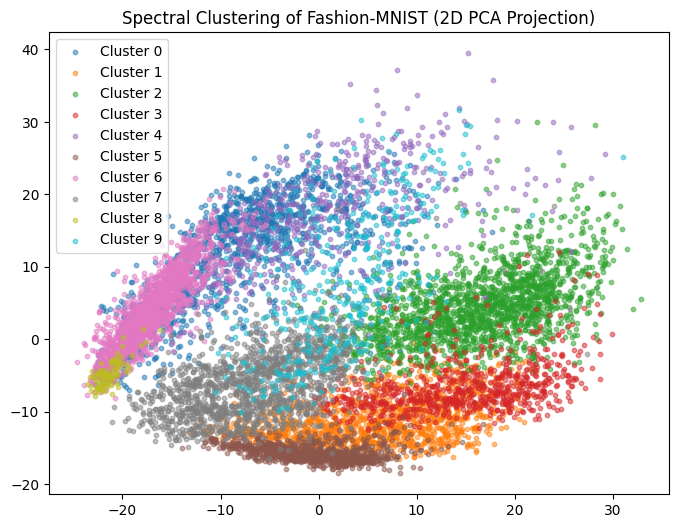

In [ ]:
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_subset)

plt.figure(figsize=(8,6))
for i in range(n_clusters):
    plt.scatter(X_2d[labels==i, 0], X_2d[labels==i, 1], label=f'Cluster {i}', s=10, alpha = 0.5)
plt.title('Spectral Clustering of Fashion-MNIST (2D PCA Projection)')
plt.legend()
plt.show()

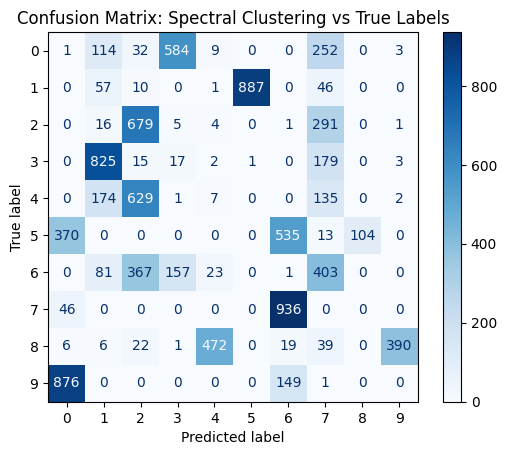

In [ ]:
cm = confusion_matrix(y_subset, labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Spectral Clustering vs True Labels')
plt.show()
